In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CMSC828C/Project 2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CMSC828C/Project 2


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from Codes.classifiers.utils import flatten, y_encoding, PCA_proj, MDA
from Codes.classifiers.logistic_regression import logistic_regression
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

USE_GPU = False
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cpu


In [4]:
# parameters
NUM_TRAIN = 60000
NUM_TEST = 10000
LEARNING_RATE = 1e-8
BATCH_SIZE = 64
N_EPOCHS = 15

N_CLASSES = 10

In [5]:
# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
# define transforms
transform = T.Compose([T.Resize((28, 28)),
                        T.ToTensor()])

mnist_train = dset.MNIST('./Datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(mnist_train, batch_size=NUM_TRAIN)

mnist_test = dset.MNIST('./Datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(mnist_test,  batch_size=NUM_TEST)

In [11]:
X_train = loader_train.dataset.data.cpu().detach().numpy()
y_train = loader_train.dataset.targets.cpu().detach().numpy()
X_test = loader_test.dataset.data.cpu().detach().numpy()
y_test = loader_test.dataset.targets.cpu().detach().numpy()

X_train = flatten(X_train)
X_test = flatten(X_test)
print(X_train.shape)
X_train_PCA, V_train = PCA_proj(X_train)
X_test_PCA = np.real(np.matmul(X_test, V_train))
print(X_train_PCA.shape)
print(y_train.shape)
print(X_test_PCA.shape)
print(y_test.shape)

(60000, 784)
---------------- PCA --------------------
60000 784
Data Centering.....
Data Centered
Covariance calculated
Eigvals and Eigvecs calculated
Required Dimension:  331
Got new clipped projection matrix
X_train projected
(60000, 331)
(60000,)
(10000, 331)
(10000,)


In [13]:
X_train_MDA, Theta = MDA(X_train, y_train, N_CLASSES)
X_test_MDA = np.real(np.matmul(X_test, Theta))
print(X_train_MDA.shape)
print(y_train.shape)
print(X_test_MDA.shape)
print(y_test.shape)

Theta shape:  (784, 9)
------------ MDA -------------
(60000, 9)
(60000,)
(10000, 9)
(10000,)


In [14]:
y_train_enc = y_encoding(y_train, N_CLASSES)
y_test_enc = y_encoding(y_test, N_CLASSES)
print(y_train_enc.shape)
print(y_test_enc.shape)

(60000, 10)
(10000, 10)


# Logistic Regression with PCA data

In [16]:
y_train_pred, train_losses, Theta  = logistic_regression(X_train_PCA, y_train_enc, LEARNING_RATE, N_EPOCHS)
print(y_train_enc)
print('Training Accuracy: ', sum(y_train_pred == y_train)/ NUM_TRAIN*100)


N, D, M:  60000 331 10
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Training Accuracy:  89.78166666666667


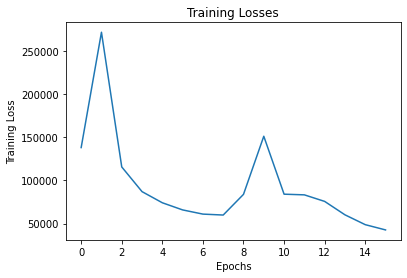

In [17]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Losses')
plt.show()

In [18]:
# Calculate Posteriors
Phi = (np.exp(X_test_PCA.dot(Theta)) / np.sum(np.exp(X_test_PCA.dot(Theta)), axis=1).reshape(NUM_TEST,1))
# Corr. Loss
loss = -1*np.sum(y_test_enc * np.log(Phi))

y_test_pred = np.argmax(Phi, axis = 1)
print('Testing Loss: ', loss)
print('Testing Accuracy: ', sum(y_test == y_test_pred)/NUM_TEST*100)

Testing Loss:  18987.99332447786
Testing Accuracy:  75.33999999999999


# Logistic Regression with MDA data

In [19]:
y_train_pred, train_losses, Theta  = logistic_regression(X_train_MDA, y_train_enc, LEARNING_RATE, N_EPOCHS)
print(y_train_enc)
print('Training Accuracy: ', sum(y_train_pred == y_train)/ NUM_TRAIN*100)


N, D, M:  60000 9 10
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Training Accuracy:  78.84666666666666


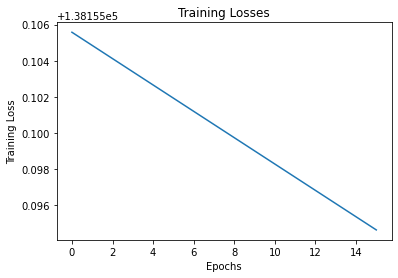

In [20]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Losses')
plt.show()

In [21]:
# Calculate Posteriors
Phi = (np.exp(X_test_MDA.dot(Theta)) / np.sum(np.exp(X_test_MDA.dot(Theta)), axis=1).reshape(NUM_TEST,1))
# Corr. Loss
loss = -1*np.sum(y_test_enc * np.log(Phi))

y_test_pred = np.argmax(Phi, axis = 1)
print('Testing Loss: ', loss)
print('Testing Accuracy: ', sum(y_test == y_test_pred)/NUM_TEST*100)

Testing Loss:  23025.84909547855
Testing Accuracy:  78.95
